In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_selection import VarianceThreshold # Feature selector
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, PowerTransformer, MaxAbsScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, chi2
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import log_loss, f1_score
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.metrics import r2_score, root_mean_squared_error, mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.ensemble import RandomForestRegressor

# Step-by-step Analysis Logic

In [ ]:
# for period_0, create a binary variable that indicates if the client invested or nor ['investment']>0
# create X, y, train_test_split
# to the training set: 
#   add results_period_1, results__period_2, results_period_3 and results_period4 to our existing training set
# create a preprocessing pipeline, that treats both numeric and categorical variables
# we checked various models, and we decided to use Random forest with calibration.
# the models we tried included a CV model with tuning, DecisionTree, RandomForest, KNN, SVM and Logistic Regression.
# after analyzing the results, specially each model's best results and their respective Confusion Matrices,
# we decided to use Logistic Regression as it calculates the probability of a client investing in the next period, had the second best score (only after RandomForest) and had the best Confusion Matrix results, in our opinion.

# apply the model to test(period_0) and check the profit (do the profit calculations)
# apply the model to period_5 and choose the top clients

# 1. Data preprocessing

In [3]:
datadir ="//Users/f3dz/Documents/catolica 24:25/s2/t3/PREDICTIVE ANALYTICS/Group Project/Project Files-20250203/"
week_0 = "period_0.csv"
week_1 = "period_1_prediction.csv"
week_2  = "period_2_prediction.csv"
week_3 = "period_3_prediction.csv"
week_4 = "period_4_prediction.csv"
week_5 = "period_5_prediction.csv"
results_1234 = "results_1234_all.csv"

In [4]:
df_0 = pd.read_csv(f"{datadir}{week_0}", sep=',')
df_1 = pd.read_csv(f"{datadir}{week_1}", sep=',')
df_2 = pd.read_csv(f"{datadir}{week_2}", sep=',')
df_3 = pd.read_csv(f"{datadir}{week_3}", sep=',')
df_4 = pd.read_csv(f"{datadir}{week_4}", sep=',')
df_5 = pd.read_csv(f"{datadir}{week_5}", sep=',')
df_results = pd.read_csv(f"{datadir}{results_1234}", sep=';')

In [5]:
df_0

,id,age,job,marital,education,preferred_contact,balance,loan_house,loan_personal,n_marketing_contacts,marketing_potential,call_length,investment,period
0,1,31,management,single,tertiary,cellular,115,no,no,0,uknown,187,256.52,0
1,2,46,admin.,married,primary,NaN,40,yes,no,0,uknown,591,0.00,0
2,3,51,blue-collar,married,secondary,NaN,0,no,yes,0,uknown,179,0.00,0
3,4,49,blue-collar,married,secondary,cellular,1127,yes,yes,1,low,162,0.00,0
4,5,50,services,married,secondary,NaN,5699,yes,no,0,uknown,381,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7545,7546,30,management,single,tertiary,cellular,1456,yes,no,0,uknown,227,0.00,0
7546,7547,60,management,single,tertiary,cellular,1034,yes,no,0,uknown,231,466.66,0
7547,7548,58,blue-collar,divorced,NaN,NaN,29,yes,no,0,uknown,253,0.00,0
7548,7549,31,technician,single,secondary,cellular,11,yes,no,0,uknown,16,0.00,0


<Axes: xlabel='investment', ylabel='Count'>

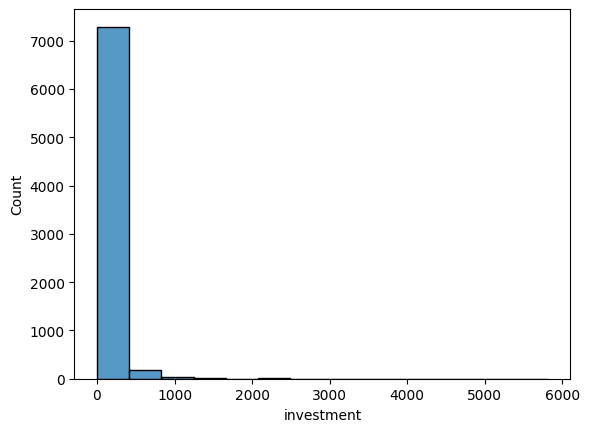

In [6]:
sns.histplot(df_0["investment"])

# 2. Prepare Data for Period_0

In [7]:
df_0 = df_0.drop(columns=['call_length', 'id', 'period'])

In [8]:
df_0['investment_binary'] = (df_0['investment'] > 0).astype(int)

In [9]:
df_0.head()

,age,job,marital,education,preferred_contact,balance,loan_house,loan_personal,n_marketing_contacts,marketing_potential,investment,investment_binary
0,31,management,single,tertiary,cellular,115,no,no,0,uknown,256.52,1
1,46,admin.,married,primary,NaN,40,yes,no,0,uknown,0.00,0
2,51,blue-collar,married,secondary,NaN,0,no,yes,0,uknown,0.00,0
3,49,blue-collar,married,secondary,cellular,1127,yes,yes,1,low,0.00,0
4,50,services,married,secondary,NaN,5699,yes,no,0,uknown,0.00,0


# 3. Split train test, X y

In [10]:
X_class = df_0.drop(columns=['investment', 'investment_binary'])
y_class = df_0['investment_binary'].values

In [11]:
# #Split data for machine learning
# X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size = 0.2, random_state = 2012)
# print(X_train_c.shape)
# print(X_test_c.shape)

In [12]:
# Split the data into three sets: train, validation and test, to avoid data leakage
train_perc = 0.4
val_perc = 0.3
test_perc = 0.3
rs = 1984

X_train_val, X_test_c, y_train_val, y_test_c = train_test_split(X_class, y_class, stratify=y_class, test_size = test_perc, random_state = rs)

X_train_c, X_val, y_train_c, y_val = train_test_split(X_train_val, y_train_val, test_size=val_perc, random_state=rs,stratify=y_train_val)

# 4. Add the results we got from Period_1, Period_2 and Period_3 to our X_train

This gives the model more information to TRAIN

We first have to merge the original values from period_1, period_2 and period_3

In [13]:
print(df_1.shape)
print(df_2.shape)
print(df_3.shape)
print(df_4.shape)

(7550, 12)
(7550, 12)
(7550, 12)
(7550, 12)


In [14]:
df_1234 = pd.concat([df_1, df_2, df_3, df_4], ignore_index=True)
df_1234.shape

(30200, 12)

Now we add the results that we have from previous weeks

In [15]:
#merge using df_results
df_results.shape

(10281, 3)

In [16]:
df_1234_final = pd.merge(df_1234, df_results, on='id', how='right')
df_1234_final.head(5)

,id,age,job,marital,education,preferred_contact,balance,loan_house,loan_personal,n_marketing_contacts,marketing_potential,period,investment,week_id
0,7557,31,management,single,tertiary,cellular,3142,yes,no,0,uknown,1,0.00,1
1,7559,31,management,single,tertiary,cellular,147,no,no,2,high,1,296.11,1
2,7563,35,admin.,married,secondary,cellular,5250,yes,no,0,uknown,1,0.00,1
3,7566,25,management,single,tertiary,cellular,3902,no,no,0,uknown,1,1019.00,1
4,7567,49,management,single,tertiary,cellular,5689,no,no,3,low,1,1398.91,1


In [17]:
df_1234_final['investment_binary']= (df_1234_final['investment'] > 0).astype(int)

drop the columns 'id', 'week_id', 'period'

In [18]:
df_1234_final = df_1234_final.drop(columns=['week_id', 'id', 'period'])
df_1234_final.shape

(10281, 12)

separate our target variable from the df_1234_final DataFrame

In [19]:
df_1234_final_X_c = df_1234_final.drop(columns=['investment', 'investment_binary'])
df_1234_final_y_c = df_1234_final['investment_binary'].values

print(df_1234_final_X_c.shape)
print(df_1234_final_y_c.shape)

(10281, 10)
(10281,)


create a bigger training set

In [20]:
X_train_c_full = pd.concat([X_train_c, df_1234_final_X_c])

In [21]:
y_train_c_full = np.concatenate([y_train_c, df_1234_final_y_c])

In [22]:
print(X_train_c_full.shape)
print(y_train_c_full.shape)

(13980, 10)
(13980,)


# 5.Apply helpful functions

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin

class DropCorrelatedColumns(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.8):  
        self.threshold = threshold
        self.to_drop = None  
        self.remaining_features = None  # Store remaining features

    def fit(self, df, y=None):
        cor_matrix = df.corr().abs()
        upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
        
        self.to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > self.threshold)]
        self.remaining_features = [col for col in df.columns if col not in self.to_drop]  # Keep remaining features
        return self

    def transform(self, df):
        return df.drop(columns=self.to_drop, axis=1)

    def get_feature_names_out(self, input_features=None):
        """Return feature names after transformation."""
        return np.array(self.remaining_features)

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin

class RelativeFreqGrouper(BaseEstimator, TransformerMixin):
    """Groups infrequent categories into 'infrequent' based on relative frequency"""
    
    def __init__(self, min_relative_freq=0.05):
        self.min_relative_freq = min_relative_freq
        self.mapping_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X)  # Convert to DataFrame if it's not already
        self.mapping_ = {}

        for col in X.columns:
            freq = X[col].value_counts(normalize=True)  # Compute relative frequency
            frequent_values = freq[freq >= self.min_relative_freq].index.tolist()
            self.mapping_[col] = set(frequent_values)

        return self

    def transform(self, X):
        X = pd.DataFrame(X)  # Ensure DataFrame format
        X_transformed = X.copy()
        
        for col in X.columns:
            X_transformed[col] = X[col].apply(lambda x: x if x in self.mapping_[col] else "infrequent")
        
        return X_transformed

    def get_feature_names_out(self, input_features=None):
        """Return feature names after transformation."""
        if input_features is None:
            return np.array([f"{col}" for col in self.mapping_.keys()])
        return np.array(input_features)

In [25]:
#extract numeric features from the X_train dataset
numeric_features = X_train_c_full.select_dtypes(include=['number']).columns.tolist()
print(numeric_features)

['age', 'balance', 'n_marketing_contacts']


In [26]:
#creates a pipeline called numeric transformer, that can process numerical features through a series of data preprocessing steps.

numeric_transformer = Pipeline(
    steps=[
        ("correlated", DropCorrelatedColumns()),              # drops correlated
        ("imputer_median", SimpleImputer(strategy="median")), # fills missings
        ("variance", VarianceThreshold(threshold = 0.08)),    # deals with little variance
        ("scaler", StandardScaler())                          # scales the data
    ])

In [27]:
#extract categorical features from the X_train dataset
categorical_features = X_train_c_full.select_dtypes(include=['object']).columns.tolist()
print(categorical_features)

['job', 'marital', 'education', 'preferred_contact', 'loan_house', 'loan_personal', 'marketing_potential']


In [28]:
#creates a pipeline, called categorical_transformer, that can process categorical features through a series of data preprocessing steps.

categorical_transformer = Pipeline(
    steps=[
        ('group', RelativeFreqGrouper(min_relative_freq=0.05)),  # groups infrequent categories
        ("imputer_missing", SimpleImputer(strategy='constant', fill_value='missing')), # fills missings
        ("encoder", OneHotEncoder(handle_unknown="ignore")), # works like get_dummies
        ("selector", SelectPercentile(chi2, percentile=50)), # can help identify and retain the most relevant features
    ]
)

In [29]:
#combined the catergorical_transformer and the numerical_transformer which preprocesses numerical and categorical features in a single step before training the model

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [30]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('TREE', DecisionTreeClassifier())
])


# 6. CV With Tuning

In [31]:
#Simple pipeline optimization

parameters = {
              'TREE__max_depth': [2,4,6,7,8,10],    # 6 max depth [2,4,6,7,8,10]
              'TREE__min_samples_split': [2,3,4,6,8],   # 3 min samples to split [2,3,4]
              'TREE__min_samples_leaf': [1,2,3,4,5]
              }      

# cv is the number of K folds, and n_jobs is the number of cores to parallelize
cv = GridSearchCV(pipeline, parameters, cv=5, verbose = True, n_jobs=4, scoring='roc_auc')

In [32]:
cv.fit(X_train_c_full, y_train_c_full)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('correlated',
                                                                                          DropCorrelatedColumns()),
                                                                                         ('imputer_median',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('variance',
                                                                                          VarianceThreshold(threshold=0.08)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'balance',
                                                                          'n_marketing_contacts']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('...
                                                                                          SelectPercentile(percentile=50,
                                                                                                           score_func=<function chi2 at 0x11ad813a0>))]),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'preferred_contact',
                                                                          'loan_house',
                                                                          'loan_personal',
                                                                          'marketing_potential'])])),
                                       ('TREE', DecisionTreeClassifier())]),
             n_jobs=4,
             param_grid={'TREE__max_depth': [2, 4, 6, 7, 8, 10],
                         'TREE__min_samples_leaf': [1, 2, 3, 4, 5],
                         'TREE__min_samples_split': [2, 3, 4, 6, 8]},
             scoring='roc_auc', verbose=True)

In [33]:
# the score is the roc_auc that we chose for the GridSearchCV
print('Training set score: ' + str(cv.score(X_train_c_full,y_train_c_full)))
print('Test set score: ' + str(cv.score(X_test_c,y_test_c)))

Training set score: 0.7807179909561673
Test set score: 0.7130193746403223


In [34]:
# Print the tuned hyperparameters and score
print("Tuned Decision Tree HyperParameters: {}".format(cv.best_params_))
print("Best score is {}".format(cv.best_score_))

Tuned Decision Tree HyperParameters: {'TREE__max_depth': 7, 'TREE__min_samples_leaf': 5, 'TREE__min_samples_split': 3}
Best score is 0.7501207023756804


In [35]:
y_pred_tuning = cv.predict(X_test_c)
y_pred_tuning

array([0, 0, 0, ..., 0, 0, 0])

In [36]:
y_prob_tuning = cv.predict_proba(X_test_c)
y_prob_tuning

array([[0.94569067, 0.05430933],
       [0.65538462, 0.34461538],
       [0.96969697, 0.03030303],
       ...,
       [0.85153893, 0.14846107],
       [0.99659864, 0.00340136],
       [0.94569067, 0.05430933]])

In [37]:
cm = confusion_matrix(y_test_c, y_pred_tuning)
print(pd.DataFrame(cm,columns = ['pred: No','pred: Yes'],index = ['real: No','real: Yes']))

           pred: No  pred: Yes
real: No       1978         27
real: Yes       220         40


In [38]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Calculate metrics
accuracy = accuracy_score(y_test_c, y_pred_tuning)
recall = recall_score(y_test_c, y_pred_tuning)
precision = precision_score(y_test_c, y_pred_tuning)
f1 = f1_score(y_test_c, y_pred_tuning)
specificity = cm[0,0] / (cm[0,0] + cm[0,1])  # Specificity = TN / (TN + FP)

In [39]:
print(f"Accuracy: {accuracy:.4f} Recall: {recall:.4f} Precision: {precision:.4f} F1 Score:{f1:.4f} Specificity: {specificity:.4f}")

Accuracy: 0.8909 Recall: 0.1538 Precision: 0.5970 F1 Score:0.2446 Specificity: 0.9865


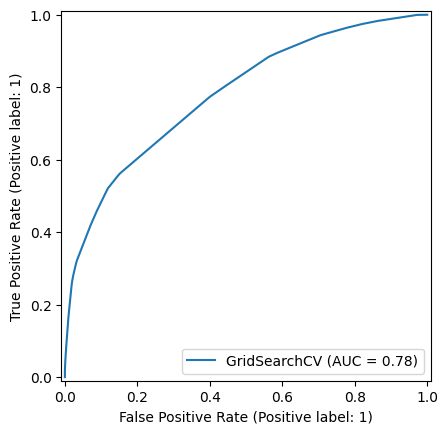

In [40]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

display = RocCurveDisplay.from_estimator(cv, X_train_c_full, y_train_c_full)
plt.show()

# 6.1 Inspect the thresholds

In [41]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_c_full,cv.predict_proba(X_train_c_full)[:,1], drop_intermediate=False)

In [42]:
# Compute the difference between TPR and FPR
diff = tpr - fpr

# Find the index of the maximum difference
inflection_point_idx = np.argmax(diff)

# Get the threshold at the inflection point
optimal_threshold = thresholds[inflection_point_idx]

# the same as thresholds[np.argmin(np.abs(fpr+tpr-1))] 
print(f"Optimal Threshold based on inflection point: {optimal_threshold}")

Optimal Threshold based on inflection point: 0.18309859154929578


# 6.2 Change the Threshold

In [43]:
y_probs = cv.predict_proba(X_test_c)[:, 1]  # Get probabilities for the positive class

threshold = 0.17647058823529413
y_pred_new = (y_probs >= threshold).astype(int)  # Predict based on the new threshold

In [44]:
cm50 = confusion_matrix(y_test_c, y_pred_tuning)
print(pd.DataFrame(cm50,columns = ['pred: No','pred: Yes'],index = ['real: No','real: Yes']))

cm_x = confusion_matrix(y_test_c, y_pred_new)
print(pd.DataFrame(cm_x,columns = ['pred: No','pred: Yes'],index = ['real: No','real: Yes']))

           pred: No  pred: Yes
real: No       1978         27
real: Yes       220         40
           pred: No  pred: Yes
real: No       1837        168
real: Yes       158        102


# 7. Using Repeated Stratified K-Fold

In [45]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV

# Define repeated stratified cross-validation
repeated_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# Define GridSearchCV
rep_stkfold = GridSearchCV(estimator=pipeline, param_grid=parameters, scoring='roc_auc', verbose=1, n_jobs=-1, 
    cv=repeated_cv   # Repeated cross-validation with k=5 (n_splits) and R=3 (n_repeats)
)

# Fit GridSearchCV
rep_stkfold.fit(X_class, y_class)

Fitting 15 folds for each of 150 candidates, totalling 2250 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=42),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('correlated',
                                                                                          DropCorrelatedColumns()),
                                                                                         ('imputer_median',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('variance',
                                                                                          VarianceThreshold(threshold=0.08)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age...
                                                                                          SelectPercentile(percentile=50,
                                                                                                           score_func=<function chi2 at 0x11ad813a0>))]),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'preferred_contact',
                                                                          'loan_house',
                                                                          'loan_personal',
                                                                          'marketing_potential'])])),
                                       ('TREE', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'TREE__max_depth': [2, 4, 6, 7, 8, 10],
                         'TREE__min_samples_leaf': [1, 2, 3, 4, 5],
                         'TREE__min_samples_split': [2, 3, 4, 6, 8]},
             scoring='roc_auc', verbose=1)

In [46]:
# the score is the roc_auc that we chose for the GridSearchCV
print('Training set score: ' + str(rep_stkfold.score(X_train_c_full,y_train_c_full)))
print('Test set score: ' + str(rep_stkfold.score(X_test_c,y_test_c)))

Training set score: 0.7360936341544626
Test set score: 0.7219643199693074


In [47]:
print(rep_stkfold.best_estimator_.get_params()['TREE'])

DecisionTreeClassifier(max_depth=6, min_samples_leaf=5, min_samples_split=3)


In [48]:
y_pred_st = rep_stkfold.predict(X_test_c)
y_pred_st

array([0, 0, 0, ..., 0, 0, 0])

In [49]:
y_prob_st = rep_stkfold.predict_proba(X_test_c)
y_prob_st

array([[0.95898778, 0.04101222],
       [0.6       , 0.4       ],
       [0.94052045, 0.05947955],
       ...,
       [0.8458498 , 0.1541502 ],
       [0.99553571, 0.00446429],
       [0.99553571, 0.00446429]])

In [50]:
cm = confusion_matrix(y_pred_st,y_test_c)
print(pd.DataFrame(cm,columns = ['pred: No','pred: Yes'],index = ['real: No','real: Yes']))

           pred: No  pred: Yes
real: No       1985        214
real: Yes        20         46


In [51]:
# Calculate metrics
accuracy = accuracy_score(y_test_c, y_pred_st)
recall = recall_score(y_test_c, y_pred_st)
precision = precision_score(y_test_c, y_pred_st)
f1 = f1_score(y_test_c, y_pred_st)
specificity = cm[0,0] / (cm[0,0] + cm[0,1])  # Specificity = TN / (TN + FP)

In [52]:
print(f"Accuracy: {accuracy:.4f} Recall: {recall:.4f} Precision: {precision:.4f} F1 Score:{f1:.4f} Specificity: {specificity:.4f}")

Accuracy: 0.8967 Recall: 0.1769 Precision: 0.6970 F1 Score:0.2822 Specificity: 0.9027


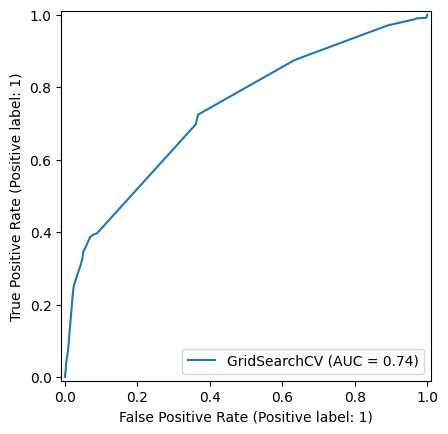

In [53]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

display = RocCurveDisplay.from_estimator(rep_stkfold, X_train_c_full, y_train_c_full)
plt.show()

# 8. Using Randomized Search

In [54]:
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=parameters, n_iter=10,
    scoring='roc_auc', cv=5, random_state=42
)

In [55]:
# Fit RandomizedSearchCV
random_search.fit(X_class, y_class)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('correlated',
                                                                                                DropCorrelatedColumns()),
                                                                                               ('imputer_median',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('variance',
                                                                                                VarianceThreshold(threshold=0.08)),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['age',
                                                                                'balance',
                                                                                'n_marketing_contacts']),
                                                                              ('cat',
                                                                               Pipeline(ste...
                                                                                                SelectPercentile(percentile=50,
                                                                                                                 score_func=<function chi2 at 0x11ad813a0>))]),
                                                                               ['job',
                                                                                'marital',
                                                                                'education',
                                                                                'preferred_contact',
                                                                                'loan_house',
                                                                                'loan_personal',
                                                                                'marketing_potential'])])),
                                             ('TREE',
                                              DecisionTreeClassifier())]),
                   param_distributions={'TREE__max_depth': [2, 4, 6, 7, 8, 10],
                                        'TREE__min_samples_leaf': [1, 2, 3, 4,
                                                                   5],
                                        'TREE__min_samples_split': [2, 3, 4, 6,
                                                                    8]},
                   random_state=42, scoring='roc_auc')

In [56]:
# the score is the roc_auc that we chose for the GridSearchCV
print('Training set score: ' + str(random_search.score(X_train_c_full,y_train_c_full)))
print('Test set score: ' + str(random_search.score(X_test_c,y_test_c)))

Training set score: 0.7360985899676695
Test set score: 0.7219624016880875


In [57]:
y_pred_random = random_search.predict(X_test_c)
y_pred_random

array([0, 0, 0, ..., 0, 0, 0])

In [58]:
y_prob_random = random_search.predict_proba(X_test_c)
y_prob_random

array([[0.95898778, 0.04101222],
       [0.6       , 0.4       ],
       [0.94052045, 0.05947955],
       ...,
       [0.8458498 , 0.1541502 ],
       [0.99553571, 0.00446429],
       [0.99553571, 0.00446429]])

In [59]:
cm = confusion_matrix(y_pred_random,y_test_c)
print(pd.DataFrame(cm,columns = ['pred: No','pred: Yes'],index = ['real: No','real: Yes']))

           pred: No  pred: Yes
real: No       1985        214
real: Yes        20         46


In [60]:
# Calculate metrics
accuracy = accuracy_score(y_test_c, y_pred_random)
recall = recall_score(y_test_c, y_pred_random)
precision = precision_score(y_test_c, y_pred_random)
f1 = f1_score(y_test_c, y_pred_random)
specificity = cm[0,0] / (cm[0,0] + cm[0,1])  # Specificity = TN / (TN + FP)

In [61]:
print(f"Accuracy: {accuracy:.4f} Recall: {recall:.4f} Precision: {precision:.4f} F1 Score:{f1:.4f} Specificity: {specificity:.4f}")

Accuracy: 0.8967 Recall: 0.1769 Precision: 0.6970 F1 Score:0.2822 Specificity: 0.9027


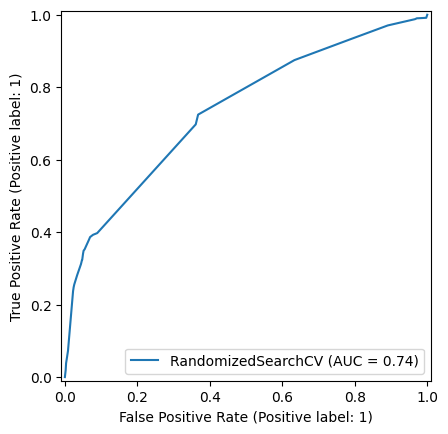

In [62]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

display = RocCurveDisplay.from_estimator(random_search, X_train_c_full, y_train_c_full)
plt.show()

# 9. Investigate Hyperparamethers

In [63]:
df_best_scores = pd.DataFrame({'Tuning':[ 'GridSearchCV', 'RepeatedStratifiedKFold', 'RandomizedSearchCV'], 

                               'Best Scores':[
                                              '{0:.3f}'.format(cv.best_score_),
                                              '{0:.3f}'.format(rep_stkfold.best_score_),
                                              '{0:.3f}'.format(random_search.best_score_)]})

print(df_best_scores)

                    Tuning Best Scores
0             GridSearchCV       0.750
1  RepeatedStratifiedKFold       0.714
2       RandomizedSearchCV       0.710


# 10.Testing SVM

In [64]:
pipeline_SV = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, random_state=2002))
])

In [65]:
# Simple pipeline optimization
parameters = {
    'classifier__C': [0.1, 1],
    'classifier__kernel': ['rbf'],
    'classifier__gamma': ['scale', 'auto', 0.01, 0.1, 1]  # Only used for 'rbf'
}

In [66]:
# Initialize GridSearchCV
svm = GridSearchCV(
    estimator=pipeline_SV,
    param_grid=parameters,
    cv=5,
    verbose=True,
    n_jobs=-1,
    scoring='roc_auc'  # Scoring method
)

In [67]:
# Fit the model
svm.fit(X_train_c_full, y_train_c_full)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('correlated',
                                                                                          DropCorrelatedColumns()),
                                                                                         ('imputer_median',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('variance',
                                                                                          VarianceThreshold(threshold=0.08)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'balance',
                                                                          'n_marketing_contacts']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('...
                                                                                                           score_func=<function chi2 at 0x11ad813a0>))]),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'preferred_contact',
                                                                          'loan_house',
                                                                          'loan_personal',
                                                                          'marketing_potential'])])),
                                       ('classifier',
                                        SVC(probability=True,
                                            random_state=2002))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1],
                         'classifier__gamma': ['scale', 'auto', 0.01, 0.1, 1],
                         'classifier__kernel': ['rbf']},
             scoring='roc_auc', verbose=True)

In [68]:
# Print best parameters and best score
print(f"Best Parameters: {svm.best_params_}")
print(f"Best CV Score: {svm.best_score_}")

Best Parameters: {'classifier__C': 0.1, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}
Best CV Score: 0.7050825252400242


In [69]:
# the score is the roc_auc that we chose for the GridSearchCV
print('Training set score: ' + str(svm.score(X_train_c_full,y_train_c_full)))
print('Test set score: ' + str(svm.score(X_test_c,y_test_c)))

Training set score: 0.7247951424752729
Test set score: 0.6368300402839057


In [70]:
y_pred_svm = svm.predict(X_test_c)
y_pred_svm

array([0, 0, 0, ..., 0, 0, 0])

In [71]:
y_prob_svm = svm.predict_proba(X_test_c)
y_prob_svm

array([[0.8691936 , 0.1308064 ],
       [0.86774256, 0.13225744],
       [0.86931117, 0.13068883],
       ...,
       [0.86914063, 0.13085937],
       [0.86915748, 0.13084252],
       [0.8719875 , 0.1280125 ]])

In [72]:
cm = confusion_matrix(y_pred_svm,y_test_c)
print(pd.DataFrame(cm,columns = ['pred: No','pred: Yes'],index = ['real: No','real: Yes']))

           pred: No  pred: Yes
real: No       1974        212
real: Yes        31         48


In [73]:
# Calculate metrics
accuracy = accuracy_score(y_test_c, y_pred_svm)
recall = recall_score(y_test_c, y_pred_svm)
precision = precision_score(y_test_c, y_pred_svm)
f1 = f1_score(y_test_c, y_pred_svm)
specificity = cm[0,0] / (cm[0,0] + cm[0,1])  # Specificity = TN / (TN + FP)

In [74]:
print(f"Accuracy: {accuracy:.4f} Recall: {recall:.4f} Precision: {precision:.4f} F1 Score:{f1:.4f} Specificity: {specificity:.4f}")

Accuracy: 0.8927 Recall: 0.1846 Precision: 0.6076 F1 Score:0.2832 Specificity: 0.9030


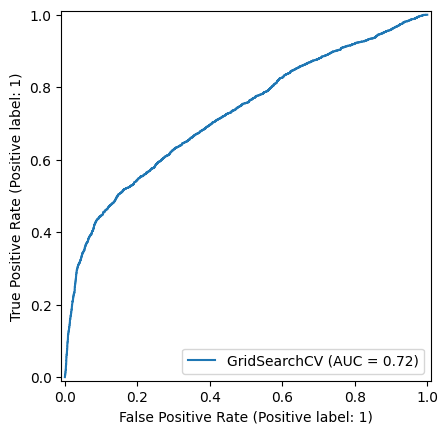

In [75]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

display = RocCurveDisplay.from_estimator(svm, X_train_c_full, y_train_c_full)
plt.show()

# 11.Random Forest

In [76]:
pipeline_RF = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight="balanced", random_state=42))
])

In [77]:
# Simple pipeline optimization
parameters = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [5, 10, 20, None],
    'classifier__min_samples_split': [2, 5, 10]
}

In [78]:
# Initialize GridSearchCV
rnd_frst = GridSearchCV(
    estimator=pipeline_RF,
    param_grid=parameters,
    cv=5,
    verbose=True,
    n_jobs=-1,
    scoring='roc_auc'  # Scoring method
)

In [79]:
# Fit the model
rnd_frst.fit(X_train_c_full, y_train_c_full)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('correlated',
                                                                                          DropCorrelatedColumns()),
                                                                                         ('imputer_median',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('variance',
                                                                                          VarianceThreshold(threshold=0.08)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'balance',
                                                                          'n_marketing_contacts']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('...
                                                                          'marital',
                                                                          'education',
                                                                          'preferred_contact',
                                                                          'loan_house',
                                                                          'loan_personal',
                                                                          'marketing_potential'])])),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [5, 10, 20, None],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [100, 200, 500]},
             scoring='roc_auc', verbose=True)

In [80]:
# Print best parameters and best score
print(f"Best Parameters: {rnd_frst.best_params_}")
print(f"Best CV Score: {rnd_frst.best_score_}")

Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 500}
Best CV Score: 0.7679410462471705


In [81]:
# the score is the roc_auc that we chose for the GridSearchCV
print('Training set score: ' + str(rnd_frst.score(X_train_c_full,y_train_c_full)))
print('Test set score: ' + str(rnd_frst.score(X_test_c,y_test_c)))

Training set score: 0.8415811316906247
Test set score: 0.7363015538077883


In [82]:
y_pred_rf = rnd_frst.predict(X_test_c)
y_pred_rf

array([0, 1, 0, ..., 1, 0, 0])

In [83]:
y_prob_rf = rnd_frst.predict_proba(X_test_c)
y_prob_rf

array([[0.74594041, 0.25405959],
       [0.4954891 , 0.5045109 ],
       [0.8670087 , 0.1329913 ],
       ...,
       [0.45955485, 0.54044515],
       [0.94475324, 0.05524676],
       [0.81153792, 0.18846208]])

In [84]:
cm = confusion_matrix(y_pred_rf,y_test_c)
print(pd.DataFrame(cm,columns = ['pred: No','pred: Yes'],index = ['real: No','real: Yes']))

           pred: No  pred: Yes
real: No       1821        151
real: Yes       184        109


In [85]:
# Calculate metrics
accuracy = accuracy_score(y_test_c, y_pred_rf)
recall = recall_score(y_test_c, y_pred_rf)
precision = precision_score(y_test_c, y_pred_rf)
f1 = f1_score(y_test_c, y_pred_rf)
specificity = cm[0,0] / (cm[0,0] + cm[0,1])  # Specificity = TN / (TN + FP)

In [86]:
print(f"Accuracy: {accuracy:.4f} Recall: {recall:.4f} Precision: {precision:.4f} F1 Score:{f1:.4f} Specificity: {specificity:.4f}")

Accuracy: 0.8521 Recall: 0.4192 Precision: 0.3720 F1 Score:0.3942 Specificity: 0.9234


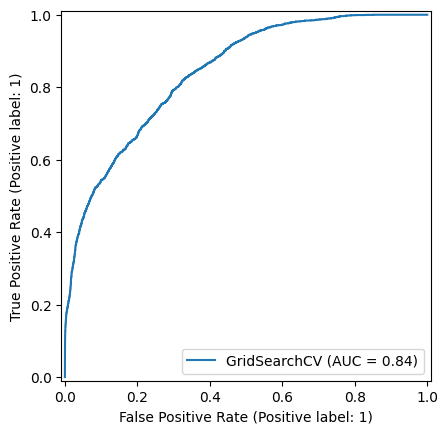

In [87]:

display = RocCurveDisplay.from_estimator(rnd_frst, X_train_c_full, y_train_c_full)
plt.show()

# 11.2 Trying RF with calibration

In [88]:
# Evaluate uncalibrated performance
preds_uncalibrated_test = rnd_frst.predict_proba(X_test_c)[:, 1]  # Predicted probabilities for positive class

In [89]:
calibrated_rf = CalibratedClassifierCV(rnd_frst, method='sigmoid', cv="prefit")
calibrated_rf.fit(X_val, y_val)  # Fit calibration using validation set
calibrated_probs = calibrated_rf.predict_proba(X_test_c)[:, 1]  # Get calibrated probabilities

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


In [90]:
calibrated_probs

array([0.06710651, 0.20551487, 0.03730237, ..., 0.23711756, 0.02538298,
       0.0489289 ])

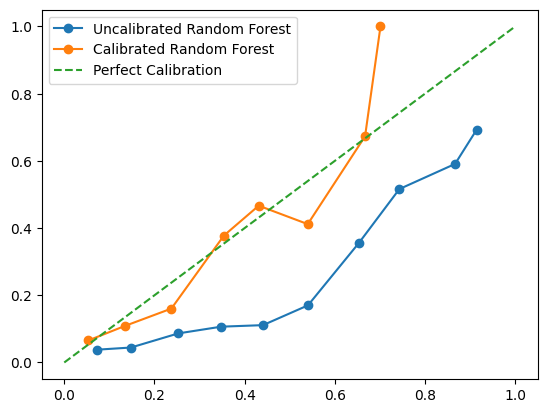

In [91]:
un_true_prob, un_pred_prob = calibration_curve(y_test_c, preds_uncalibrated_test, n_bins=10)
true_prob, pred_prob = calibration_curve(y_test_c, calibrated_probs, n_bins=10)

plt.plot(un_pred_prob, un_true_prob, marker = 'o', label = 'Uncalibrated Random Forest')
plt.plot(pred_prob, true_prob, marker = 'o', label = 'Calibrated Random Forest')
plt.plot([0,1], [0,1], linestyle = '--', label = 'Perfect Calibration')
plt.legend()

# 12.KNN

In [92]:
pipeline_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

In [93]:
parameters = {
    'classifier__n_neighbors': [3, 7],  # Number of neighbors to use
    'classifier__weights': ['uniform'], # Weight function used in prediction
    'classifier__p': [1]                # Power parameter for the Minkowski metric 1 manhattan and 2 euclidean
}

In [94]:
# Initialize GridSearchCV
knn = GridSearchCV(
    estimator=pipeline_knn, # With KNN 
    param_grid=parameters,
    cv=5,
    verbose=True,
    n_jobs=-1,
    scoring='roc_auc'       # Scoring method for classification
)

In [95]:
# Fit the model
knn.fit(X_train_c_full, y_train_c_full)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('correlated',
                                                                                          DropCorrelatedColumns()),
                                                                                         ('imputer_median',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('variance',
                                                                                          VarianceThreshold(threshold=0.08)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'balance',
                                                                          'n_marketing_contacts']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('...
                                                                                          SelectPercentile(percentile=50,
                                                                                                           score_func=<function chi2 at 0x11ad813a0>))]),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'preferred_contact',
                                                                          'loan_house',
                                                                          'loan_personal',
                                                                          'marketing_potential'])])),
                                       ('classifier', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__n_neighbors': [3, 7],
                         'classifier__p': [1],
                         'classifier__weights': ['uniform']},
             scoring='roc_auc', verbose=True)

In [96]:
# Print best parameters and best score
print(f"Best Parameters: {knn.best_params_}")
print(f"Best CV Score: {knn.best_score_}")

Best Parameters: {'classifier__n_neighbors': 7, 'classifier__p': 1, 'classifier__weights': 'uniform'}
Best CV Score: 0.7097457736417956


In [97]:
# the score is the roc_auc that we chose for the GridSearchCV
print('Training set score: ' + str(knn.score(X_train_c_full,y_train_c_full)))
print('Test set score: ' + str(knn.score(X_test_c,y_test_c)))

Training set score: 0.8740875086241134
Test set score: 0.6712286591214272


In [98]:
y_pred_knn = knn.predict(X_test_c)
y_pred_knn

array([0, 0, 0, ..., 0, 0, 0])

In [99]:
y_prob_knn = knn.predict_proba(X_test_c)
y_prob_knn

array([[1.        , 0.        ],
       [0.57142857, 0.42857143],
       [1.        , 0.        ],
       ...,
       [0.71428571, 0.28571429],
       [1.        , 0.        ],
       [1.        , 0.        ]])

In [100]:
cm = confusion_matrix(y_pred_knn,y_test_c)
print(pd.DataFrame(cm,columns = ['pred: No','pred: Yes'],index = ['real: No','real: Yes']))

           pred: No  pred: Yes
real: No       1959        212
real: Yes        46         48


In [101]:
print("Best score is {}".format(knn.best_score_))

Best score is 0.7097457736417956


In [102]:
# Calculate metrics
accuracy = accuracy_score(y_test_c, y_pred_knn)
recall = recall_score(y_test_c, y_pred_knn)
precision = precision_score(y_test_c, y_pred_knn)
f1 = f1_score(y_test_c, y_pred_knn)
specificity = cm[0,0] / (cm[0,0] + cm[0,1])  # Specificity = TN / (TN + FP)

In [103]:
print(f"Accuracy: {accuracy:.4f} Recall: {recall:.4f} Precision: {precision:.4f} F1 Score:{f1:.4f} Specificity: {specificity:.4f}")

Accuracy: 0.8861 Recall: 0.1846 Precision: 0.5106 F1 Score:0.2712 Specificity: 0.9023


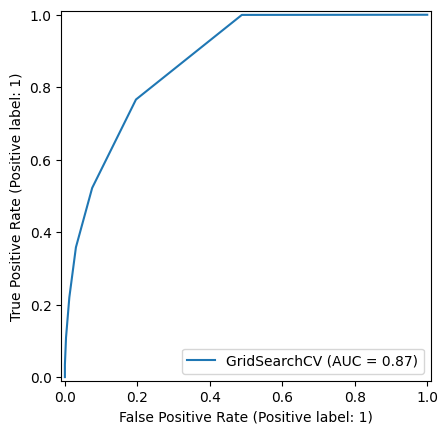

In [104]:

display = RocCurveDisplay.from_estimator(knn, X_train_c_full, y_train_c_full)
plt.show()

# 13.Logistic regression

In [105]:
pipeline_LR = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced',max_iter=1000, solver='liblinear'))
])

In [106]:
# Simple pipeline optimization
parameters = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2']
}

In [107]:
# Initialize GridSearchCV
log_reg = GridSearchCV(
    estimator=pipeline_LR,
    param_grid=parameters,
    cv=5,
    verbose=True,
    n_jobs=-1,
    scoring='roc_auc'  # Scoring method
)

In [108]:
# Fit the model
log_reg.fit(X_train_c_full, y_train_c_full)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('correlated',
                                                                                          DropCorrelatedColumns()),
                                                                                         ('imputer_median',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('variance',
                                                                                          VarianceThreshold(threshold=0.08)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'balance',
                                                                          'n_marketing_contacts']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('...
                                                                                                           score_func=<function chi2 at 0x11ad813a0>))]),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'preferred_contact',
                                                                          'loan_house',
                                                                          'loan_personal',
                                                                          'marketing_potential'])])),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1, 10],
                         'classifier__penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=True)

In [109]:
# Print best parameters and best score
print(f"Best Parameters: {log_reg.best_params_}")
print(f"Best CV Score: {log_reg.best_score_}")

Best Parameters: {'classifier__C': 10, 'classifier__penalty': 'l1'}
Best CV Score: 0.7557949884996723


In [110]:
# the score is the roc_auc that we chose for the GridSearchCV
print('Training set score: ' + str(log_reg.score(X_train_c_full,y_train_c_full)))
print('Test set score: ' + str(log_reg.score(X_test_c,y_test_c)))

Training set score: 0.7595303101710967
Test set score: 0.72500191828122


In [111]:
y_pred_log = log_reg.predict(X_test_c)
y_pred_log

array([0, 1, 0, ..., 1, 0, 0])

In [112]:
y_prob_log = log_reg.predict_proba(X_test_c)
y_prob_log

array([[0.8148043 , 0.1851957 ],
       [0.4369787 , 0.5630213 ],
       [0.87109509, 0.12890491],
       ...,
       [0.42300967, 0.57699033],
       [0.80389431, 0.19610569],
       [0.6851688 , 0.3148312 ]])

In [113]:
cm = confusion_matrix(y_pred_log,y_test_c)
print(pd.DataFrame(cm,columns = ['pred: No','pred: Yes'],index = ['real: No','real: Yes']))

           pred: No  pred: Yes
real: No       1711        140
real: Yes       294        120


In [114]:
# Calculate metrics
accuracy = accuracy_score(y_test_c, y_pred_log)
recall = recall_score(y_test_c, y_pred_log)
precision = precision_score(y_test_c, y_pred_log)
f1 = f1_score(y_test_c, y_pred_log)
specificity = cm[0,0] / (cm[0,0] + cm[0,1])  # Specificity = TN / (TN + FP)

In [115]:
print(f"Accuracy: {accuracy:.4f} Recall: {recall:.4f} Precision: {precision:.4f} F1 Score:{f1:.4f} Specificity: {specificity:.4f}")

Accuracy: 0.8084 Recall: 0.4615 Precision: 0.2899 F1 Score:0.3561 Specificity: 0.9244


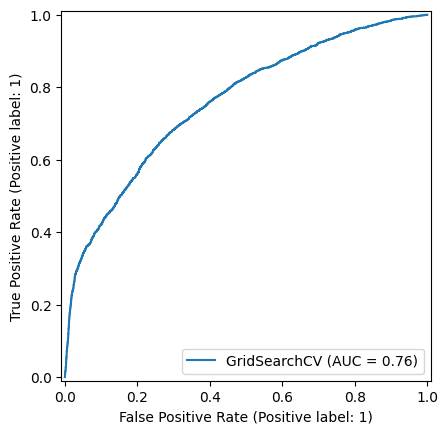

In [116]:

display = RocCurveDisplay.from_estimator(log_reg, X_train_c_full, y_train_c_full)
plt.show()

# 14. GradientBoosting


In [117]:
# Add a FunctionTransformer to convert sparse to dense
dense_transformer = FunctionTransformer(lambda x: x.toarray() if hasattr(x, "toarray") else x)

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('to_dense', dense_transformer),  # Ensures dense data as HistGradientBoostingClassifier does not support sparse matrices as input
    ('classifier', HistGradientBoostingClassifier(random_state=1984))
])

In [118]:
# Simple pipeline optimization
parameters = {
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [3, 5],
    'classifier__max_iter': [50, 100],  # Equivalent to n_estimators
    'classifier__scoring': ['loss'],   # Use scoring directly
}

In [119]:
# Initialize GridSearchCV
lgbm_clf = GridSearchCV(
    estimator=pipeline,
    param_grid=parameters,
    cv=5,
    verbose=True,
    n_jobs=-1,
    scoring='roc_auc'  # roc_auc focuses on ranking, while logloss focuses on probability calibration
)

In [120]:
# Fit the model
lgbm_clf.fit(X_train_c_full, y_train_c_full)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('correlated',
                                                                                          DropCorrelatedColumns()),
                                                                                         ('imputer_median',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('variance',
                                                                                          VarianceThreshold(threshold=0.08)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'balance',
                                                                          'n_marketing_contacts']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('...
                                                                          'marketing_potential'])])),
                                       ('to_dense',
                                        FunctionTransformer(func=<function <lambda> at 0x11e7944a0>)),
                                       ('classifier',
                                        HistGradientBoostingClassifier(random_state=1984))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.1],
                         'classifier__max_depth': [3, 5],
                         'classifier__max_iter': [50, 100],
                         'classifier__scoring': ['loss']},
             scoring='roc_auc', verbose=True)

In [121]:
print('Training set score: ' + str(lgbm_clf.score(X_train_c_full,y_train_c_full)))
print('Test set score: ' + str(lgbm_clf.score(X_test_c,y_test_c)))

Training set score: 0.7920368141767191
Test set score: 0.7419662382505274


In [122]:
y_pred_un = lgbm_clf.predict(X_test_c)
y_pred_un

array([0, 0, 0, ..., 0, 0, 0])

In [123]:
y_prob_un = lgbm_clf.predict_proba(X_test_c)
y_prob_un

array([[0.93564717, 0.06435283],
       [0.69907902, 0.30092098],
       [0.96606196, 0.03393804],
       ...,
       [0.80720395, 0.19279605],
       [0.97288049, 0.02711951],
       [0.93241098, 0.06758902]])

In [124]:
cm = confusion_matrix(y_pred_un,y_test_c)
print(pd.DataFrame(cm,columns = ['pred: No','pred: Yes'],index = ['real: No','real: Yes']))

           pred: No  pred: Yes
real: No       1981        218
real: Yes        24         42


In [125]:
# Calculate metrics
accuracy = accuracy_score(y_test_c, y_pred_un)
recall = recall_score(y_test_c, y_pred_un)
precision = precision_score(y_test_c, y_pred_un)
f1 = f1_score(y_test_c, y_pred_un)
specificity = cm[0,0] / (cm[0,0] + cm[0,1])  # Specificity = TN / (TN + FP)

In [126]:
print(f"Accuracy: {accuracy:.4f} Recall: {recall:.4f} Precision: {precision:.4f} F1 Score:{f1:.4f} Specificity: {specificity:.4f}")

Accuracy: 0.8932 Recall: 0.1615 Precision: 0.6364 F1 Score:0.2577 Specificity: 0.9009


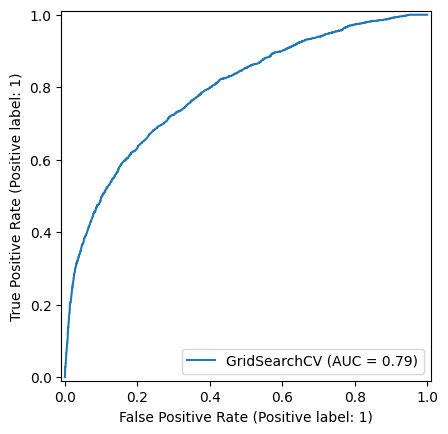

In [127]:

display = RocCurveDisplay.from_estimator(lgbm_clf, X_train_c_full, y_train_c_full)
plt.show()

In [128]:
print(f"Best LOG CV Score: {log_reg.best_score_}")
print(f"Best KNN CV Score: {knn.best_score_}")
print(f"Best RF CV Score: {rnd_frst.best_score_}")
print(f"Best SVM CV Score: {svm.best_score_}")
print(f"Best CV Score: {cv.best_score_}")
print(f"Best RS K-fold Score: {rep_stkfold.best_score_}")
print(f"Best Random search Score: {random_search.best_score_}")
print(f"Best Gradient Boosting Score: {lgbm_clf.best_score_}")


Best LOG CV Score: 0.7557949884996723
Best KNN CV Score: 0.7097457736417956
Best RF CV Score: 0.7679410462471705
Best SVM CV Score: 0.7050825252400242
Best CV Score: 0.7501207023756804
Best RS K-fold Score: 0.7142885516596347
Best Random search Score: 0.7102110951459035
Best Gradient Boosting Score: 0.7725722150502276


# 15.Graphical analysis

In [129]:

# Dictionary to store cv_results_ for the different predictors
results_dict = {
    'Grid Search': cv.cv_results_,
    'Stratified': rep_stkfold.cv_results_,
    'Randomized': random_search.cv_results_,
    'SVM': svm.cv_results_,
    'Random Forest': rnd_frst.cv_results_,
    'KNN': knn.cv_results_,
    'Logistic Regression': log_reg.cv_results_,
    'HistGradientBoosting': lgbm_clf.cv_results_
}

# Combine all results into a single DataFrame with a predictor column
combined_df = pd.concat(
    [pd.DataFrame(res).assign(predictor=name) for name, res in results_dict.items()],
    ignore_index=True
)

<Figure size 2400x1000 with 0 Axes>

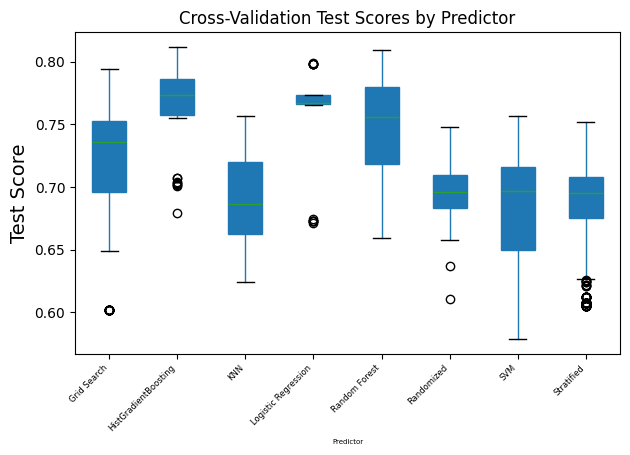

In [130]:
# Extract relevant columns for plotting
# 'splitN_test_score' columns contain the test scores for each split
split_columns = [col for col in combined_df.columns if 'split' in col and '_test_score' in col]

# Melt the DataFrame to reshape it for boxplot
melted_df = pd.melt(
    combined_df,
    id_vars=['predictor'],
    value_vars=split_columns,
    var_name='fold',
    value_name='test_score'
)

# Plot the box-and-whisker plot
plt.figure(figsize=(24, 10))

# Create boxplot grouped by predictors
melted_df.boxplot(by='predictor', column='test_score', grid=False, patch_artist=True)

# Customize plot
plt.title('Cross-Validation Test Scores by Predictor')
plt.suptitle("")  # Remove default title added by boxplot
plt.xticks(rotation=45, ha='right', fontsize=6)
plt.xlabel('Predictor', fontsize=5)  # Adjust the fontsize as desired
plt.ylabel('Test Score', fontsize=14)
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()





# Data Preprocessing, training and testing for Regression model

In [131]:
df_0

,age,job,marital,education,preferred_contact,balance,loan_house,loan_personal,n_marketing_contacts,marketing_potential,investment,investment_binary
0,31,management,single,tertiary,cellular,115,no,no,0,uknown,256.52,1
1,46,admin.,married,primary,NaN,40,yes,no,0,uknown,0.00,0
2,51,blue-collar,married,secondary,NaN,0,no,yes,0,uknown,0.00,0
3,49,blue-collar,married,secondary,cellular,1127,yes,yes,1,low,0.00,0
4,50,services,married,secondary,NaN,5699,yes,no,0,uknown,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7545,30,management,single,tertiary,cellular,1456,yes,no,0,uknown,0.00,0
7546,60,management,single,tertiary,cellular,1034,yes,no,0,uknown,466.66,1
7547,58,blue-collar,divorced,NaN,NaN,29,yes,no,0,uknown,0.00,0
7548,31,technician,single,secondary,cellular,11,yes,no,0,uknown,0.00,0


In [132]:
df_0 = df_0[df_0['investment'] > 0]
df_0

,age,job,marital,education,preferred_contact,balance,loan_house,loan_personal,n_marketing_contacts,marketing_potential,investment,investment_binary
0,31,management,single,tertiary,cellular,115,no,no,0,uknown,256.52,1
6,42,admin.,divorced,secondary,NaN,153,yes,no,0,uknown,250.31,1
12,32,technician,single,tertiary,telephone,5514,no,no,0,uknown,782.06,1
24,38,services,married,secondary,cellular,5293,yes,no,6,low,766.41,1
25,35,self-employed,single,tertiary,cellular,353,no,no,0,uknown,303.14,1
...,...,...,...,...,...,...,...,...,...,...,...,...
7507,32,admin.,single,secondary,cellular,344,no,no,0,uknown,285.08,1
7515,37,admin.,married,secondary,cellular,1967,no,no,1,high,443.01,1
7519,51,housemaid,married,NaN,cellular,2337,yes,no,3,uknown,478.03,1
7521,31,management,single,tertiary,cellular,3340,no,no,3,high,915.20,1


In [133]:
X_reg = df_0.drop(columns=['investment',"investment_binary"])
y_reg = df_0['investment'].values

In [134]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg,  y_reg, test_size = 0.2, random_state = 2002)
print(X_train_r.shape)
print(X_test_r.shape)

(692, 10)
(174, 10)


# 1.Add more data to training set

In [135]:
df_1234_final = df_1234_final[df_1234_final['investment']>0]
df_1234_final.shape

(1949, 12)

separate our target variable from the df_123_final DataFrame

In [136]:
df_1234_final_X_r = df_1234_final.drop(columns=['investment', 'investment_binary'])
df_1234_final_y_r = df_1234_final['investment'].values

print(df_1234_final_X_r.shape)
print(df_1234_final_y_r.shape)

(1949, 10)
(1949,)


create a bigger training set

In [137]:
X_train_r_full = pd.concat([X_train_r, df_1234_final_X_r])

In [138]:
y_train_r_full = np.concatenate([y_train_r, df_1234_final_y_r])

In [139]:
print(X_train_r_full.shape)
print(y_train_r_full.shape)

(2641, 10)
(2641,)


# 2. Apply helpful functions - Regression Model

In [140]:
numeric_features_reg = X_train_r_full.select_dtypes(include=['number']).columns.tolist()
categorical_features_reg = X_train_r_full.select_dtypes(include=['object']).columns.tolist()
print(numeric_features_reg)
print(categorical_features_reg)

['age', 'balance', 'n_marketing_contacts']
['job', 'marital', 'education', 'preferred_contact', 'loan_house', 'loan_personal', 'marketing_potential']


In [141]:
preprocessor_reg = ColumnTransformer([
    ('num', StandardScaler(), numeric_features_reg),
    ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_features_reg)  
])

In [142]:
pipeline_reg = Pipeline([
    ('preprocessor', preprocessor_reg),
    ('interaction', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('regressor', LinearRegression())
])

In [143]:
# Define hyperparameters
param_grid = {
    'regressor__fit_intercept': [True, False],
    'regressor__positive': [True, False],
    'interaction__degree': [1, 2]
}

# 3.Linear regression and metrics checking

In [144]:
# Fit the pipeline on training data
pipeline_reg.fit(X_train_r_full, y_train_r_full)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'balance',
                                                   'n_marketing_contacts']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education',
                                                   'preferred_contact',
                                                   'loan_house',
                                                   'loan_personal',
                                                   'marketing_potential'])])),
                ('interaction',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('regressor', LinearRegression())])

In [145]:
y_pred_reg = pipeline_reg.predict(X_test_r)

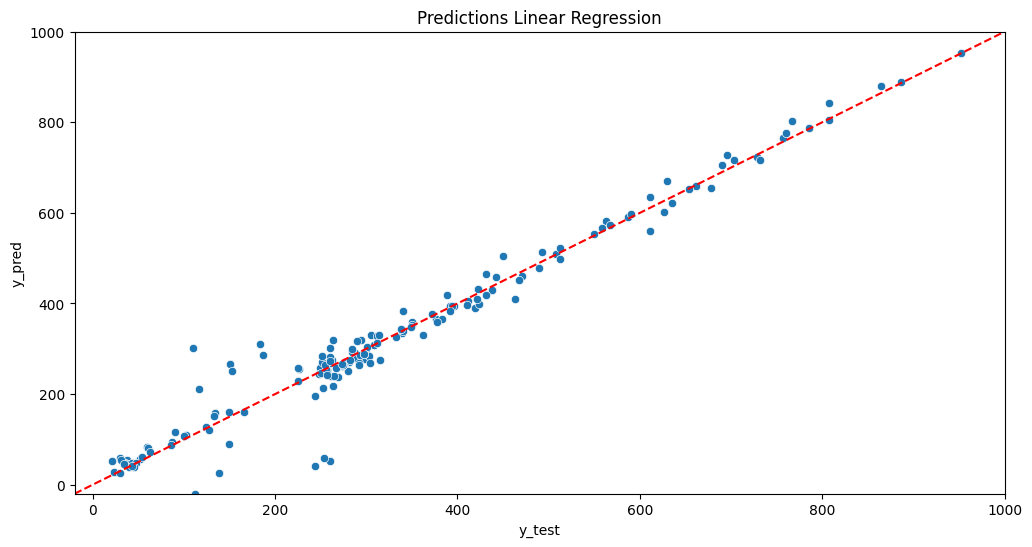

In [146]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test_r, y=y_pred_reg)

# Set the same scale for both axes
plt.xlim(-20, 1000)
plt.ylim(-20, 1000)

# Plot a diagonal reference line (y = x)
plt.plot([-20, 1000], [-20, 1000], color='red', linestyle='--')

plt.title("Predictions Linear Regression")
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [147]:
print("                   MAE             MSE           RMSE          MedAE         R2")
print("Linear Regression {:.12} {:.10f} {:.8f} {:.8f} {:.8f}"
        .format(mean_absolute_error(y_test_r, y_pred_reg),
                mean_squared_error(y_test_r,y_pred_reg),
                root_mean_squared_error(y_test_r,y_pred_reg),
                median_absolute_error(y_test_r,y_pred_reg),
                r2_score(y_test_r,y_pred_reg)))

                   MAE             MSE           RMSE          MedAE         R2
Linear Regression 23.9578395119 1851.8830518589 43.03351080 11.94498805 0.98523976


# 4.Random forest as regression

In [148]:
pipeline_rf_reg = Pipeline([
    ('preprocessor', preprocessor_reg),
    # No need for PolynomialFeatures with Random Forest as it can capture non-linear relationships
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=2002))
])

In [149]:

# Define hyperparameters for RandomForestRegressor
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}


In [150]:
# The rest of your code remains the same
# Fit the pipeline
pipeline_rf_reg.fit(X_train_r_full, y_train_r_full)

# Make predictions
y_pred_rf_reg = pipeline_rf_reg.predict(X_test_r)

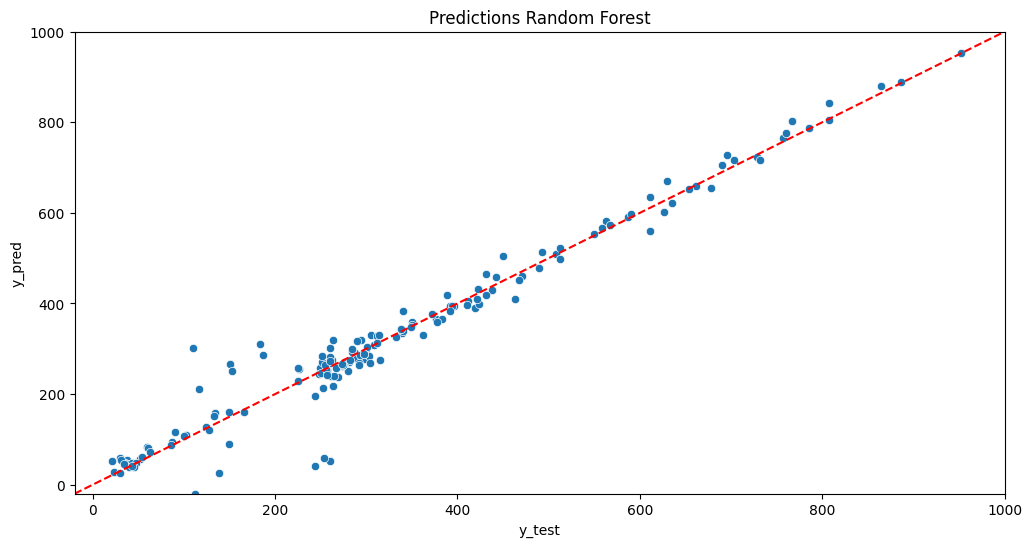

In [151]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test_r, y=y_pred_reg)

# Set the same scale for both axes
plt.xlim(-20, 1000)
plt.ylim(-20, 1000)

# Plot a diagonal reference line (y = x)
plt.plot([-20, 1000], [-20, 1000], color='red', linestyle='--')

plt.title("Predictions Random Forest")
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [152]:
print("                   MAE             MSE           RMSE          MedAE         R2")
print("RF Regression {:.12} {:.10f} {:.8f} {:.8f} {:.8f}"
        .format(mean_absolute_error(y_test_r, y_pred_rf_reg),
                mean_squared_error(y_test_r,y_pred_rf_reg),
                root_mean_squared_error(y_test_r,y_pred_rf_reg),
                median_absolute_error(y_test_r,y_pred_rf_reg),
                r2_score(y_test_r,y_pred_rf_reg)))

                   MAE             MSE           RMSE          MedAE         R2
RF Regression 13.4714799234 439.6553985016 20.96796124 9.60435000 0.99649577


# 5. Apply to Period_5

In [153]:
original_ids = df_5.drop(columns=['age', 'job', 'marital', 'education', 
                                            'preferred_contact', 'balance', 'loan_house', 'loan_personal', 
                                            'n_marketing_contacts', 'marketing_potential', 'period'])

In [154]:
y_prob_period_5 = calibrated_rf.predict_proba(df_5.drop(columns=['id','period']))

In [155]:
df_5_final = df_5.copy()

In [156]:
df_5_final['predict_proba_yes'] = y_prob_period_5[:,1]

In [157]:
y_pred_reg_period_5 = pipeline_rf_reg.predict(df_5.drop(columns=['id','period']))

In [158]:
df_5_final['predict_investment'] = y_pred_reg_period_5

In [159]:
df_5_final['expected_profit'] = df_5_final['predict_proba_yes'] * (df_5_final['predict_investment']* 0.05) - 5

In [160]:
df_5_final

,id,age,job,marital,education,preferred_contact,balance,loan_house,loan_personal,n_marketing_contacts,marketing_potential,period,predict_proba_yes,predict_investment,expected_profit
0,37751,50,housemaid,married,primary,cellular,0,no,no,0,uknown,5,0.060878,256.0909,-4.220489
1,37752,39,services,married,secondary,NaN,-540,no,no,0,uknown,5,0.028828,238.6012,-4.656077
2,37753,45,self-employed,married,secondary,cellular,1051,no,no,0,uknown,5,0.127056,361.2922,-2.704790
3,37754,29,admin.,single,secondary,cellular,127,yes,yes,0,uknown,5,0.061947,108.0255,-4.665407
4,37755,45,management,divorced,tertiary,cellular,839,yes,no,0,uknown,5,0.074500,412.0228,-3.465217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7456,45207,49,technician,married,secondary,cellular,0,yes,no,0,uknown,5,0.074320,247.5905,-4.079950
7457,45208,49,admin.,married,secondary,cellular,1047,no,no,0,uknown,5,0.123796,350.1688,-2.832521
7458,45209,32,blue-collar,married,primary,NaN,206,yes,no,0,uknown,5,0.027335,275.2725,-4.623770
7459,45210,44,technician,divorced,tertiary,NaN,9192,yes,no,0,uknown,5,0.054918,1157.0323,-1.822886


In [161]:
df_5_final = df_5_final.sort_values(by='expected_profit', ascending=False)

In [162]:
df_5_final

,id,age,job,marital,education,preferred_contact,balance,loan_house,loan_personal,n_marketing_contacts,marketing_potential,period,predict_proba_yes,predict_investment,expected_profit
4329,42080,42,management,married,tertiary,cellular,27696,no,no,5,high,5,0.573791,5710.8125,158.840707
3754,41505,34,management,single,tertiary,cellular,13014,no,no,1,high,5,0.649726,2829.8338,86.930860
2632,40383,42,management,single,tertiary,cellular,11008,no,no,1,high,5,0.654358,2440.0265,74.832489
2911,40662,31,management,single,tertiary,cellular,44128,no,no,0,uknown,5,0.230649,5216.6450,55.160713
3652,41403,49,management,divorced,tertiary,cellular,20727,no,no,2,low,5,0.255552,4230.6025,49.056854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1325,39076,59,retired,married,tertiary,NaN,135,yes,no,0,uknown,5,0.026621,32.1638,-4.957189
6251,44002,56,retired,married,primary,NaN,133,no,yes,0,uknown,5,0.024846,32.4810,-4.959648
2776,40527,58,retired,married,tertiary,NaN,44,yes,no,0,uknown,5,0.025162,30.3580,-4.961806
419,38170,57,retired,married,primary,NaN,70,yes,yes,0,uknown,5,0.025154,28.4051,-4.964275


In [163]:
for threshold in [400, 500, 600, 700, 750, 800, 850, 900, 950, 1000, 1500]:
    selected_clients = df_5_final.head(threshold)
    total_profit = selected_clients['expected_profit'].sum()
    print(f"Total profit for top {threshold} clients: {total_profit}")


Total profit for top 400 clients: 4679.895006868265
Total profit for top 500 clients: 4993.655439288215
Total profit for top 600 clients: 5196.932604792755
Total profit for top 700 clients: 5312.961304473031
Total profit for top 750 clients: 5342.463822403299
Total profit for top 800 clients: 5360.414726091622
Total profit for top 850 clients: 5365.124464587425
Total profit for top 900 clients: 5357.57776949233
Total profit for top 950 clients: 5338.328891595881
Total profit for top 1000 clients: 5308.176087082552
Total profit for top 1500 clients: 4579.251229335336


In [164]:
top_clients = df_5_final.head(825)

In [165]:
top_clients['expected_profit'].sum()

np.float64(5363.990483923247)

In [166]:
final_submission = top_clients.drop(columns=['job','age', 'marital', 'education', 'preferred_contact', 'balance', 'loan_house', 'loan_personal', 'n_marketing_contacts', 'marketing_potential', 'period', 'predict_proba_yes', 'predict_investment', 'expected_profit'])

In [167]:
final_submission['target'] = 1
final_submission

,id,target
4329,42080,1
3754,41505,1
2632,40383,1
2911,40662,1
3652,41403,1
...,...,...
7264,45015,1
882,38633,1
279,38030,1
2273,40024,1


In [168]:
final_id = original_ids.merge(final_submission, on='id', how='left')
final_id

,id,target
0,37751,NaN
1,37752,NaN
2,37753,NaN
3,37754,NaN
4,37755,NaN
...,...,...
7456,45207,NaN
7457,45208,NaN
7458,45209,NaN
7459,45210,NaN


In [169]:
final_id['target'] = final_id['target'].fillna(0).astype(int)


In [170]:
final_id.set_index("id", inplace=True)

In [171]:
final_id

,target
id,
37751,0
37752,0
37753,0
37754,0
37755,0
...,...
45207,0
45208,0
45209,0


In [172]:
df_5_final

,id,age,job,marital,education,preferred_contact,balance,loan_house,loan_personal,n_marketing_contacts,marketing_potential,period,predict_proba_yes,predict_investment,expected_profit
4329,42080,42,management,married,tertiary,cellular,27696,no,no,5,high,5,0.573791,5710.8125,158.840707
3754,41505,34,management,single,tertiary,cellular,13014,no,no,1,high,5,0.649726,2829.8338,86.930860
2632,40383,42,management,single,tertiary,cellular,11008,no,no,1,high,5,0.654358,2440.0265,74.832489
2911,40662,31,management,single,tertiary,cellular,44128,no,no,0,uknown,5,0.230649,5216.6450,55.160713
3652,41403,49,management,divorced,tertiary,cellular,20727,no,no,2,low,5,0.255552,4230.6025,49.056854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1325,39076,59,retired,married,tertiary,NaN,135,yes,no,0,uknown,5,0.026621,32.1638,-4.957189
6251,44002,56,retired,married,primary,NaN,133,no,yes,0,uknown,5,0.024846,32.4810,-4.959648
2776,40527,58,retired,married,tertiary,NaN,44,yes,no,0,uknown,5,0.025162,30.3580,-4.961806
419,38170,57,retired,married,primary,NaN,70,yes,yes,0,uknown,5,0.025154,28.4051,-4.964275


# Cumulative response curve

In [173]:
# Calculate cumulative response
cumulative = np.cumsum(df_5_final["expected_profit"])  # Cumulative sum of true positives
baseline = np.linspace(0, sum(df_5_final["expected_profit"]), len(df_5_final["expected_profit"]))  # Baseline response

# Calculate lift
population_percentage = np.arange(1, len(df_5_final["expected_profit"]) + 1) / len(df_5_final["expected_profit"]) * 100  # % of population
lift = cumulative / baseline  # Lift is the ratio of actual response to baseline

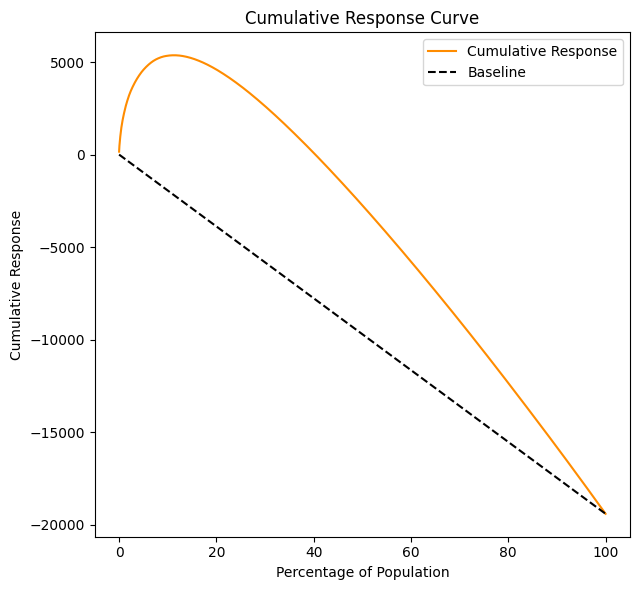

In [174]:
# Plot the curves
plt.figure(figsize=(12, 6))

# Cumulative Response Curve
plt.subplot(1, 2, 1)
plt.plot(population_percentage, cumulative, label="Cumulative Response", color="darkorange")  # Changed to dark orange
plt.plot(population_percentage, baseline, label="Baseline", color="black", linestyle="--")  # Changed to black
plt.title("Cumulative Response Curve")
plt.xlabel("Percentage of Population")
plt.ylabel("Cumulative Response")
plt.legend()

plt.tight_layout()
plt.show()

# Profit Curve

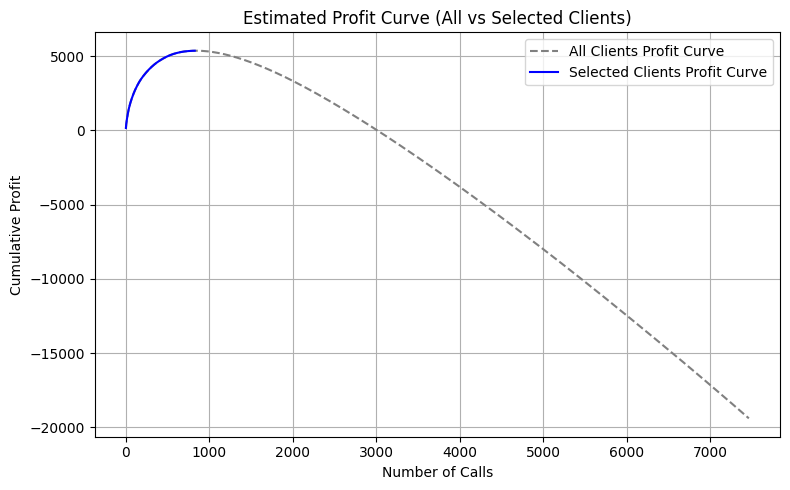

In [175]:
# Generate Profit Curve
plt.figure(figsize=(8, 5))

df_5_final.loc[:, 'expected_profit'] = (
    df_5_final['predict_proba_yes'] * 
    (df_5_final['predict_investment'] * 0.05 - 5) +  
    (1 - df_5_final['predict_proba_yes']) * (-5)
)

# Sort all period_5 clients by expected profit
period_5_sorted = df_5_final.sort_values(by='expected_profit', ascending=False)

# Cumulative sum of profits for each additional client called
cumulative_profit_all = period_5_sorted['expected_profit'].cumsum()

# Number of calls (x-axis) for all period_5 clients
num_calls_all = np.arange(1, len(period_5_sorted) + 1)

# Plot profit curve for ALL period_5 clients
plt.plot(num_calls_all, cumulative_profit_all, color="gray", linestyle="dashed", label="All Clients Profit Curve")

# Sort final clients by expected profit
final_clients_sorted = top_clients.sort_values(by='expected_profit', ascending=False)

# Cumulative sum of profits for selected clients
cumulative_profit_selected = final_clients_sorted['expected_profit'].cumsum()
num_calls_selected = np.arange(1, len(final_clients_sorted) + 1)

# Plot profit curve for SELECTED clients
plt.plot(num_calls_selected, cumulative_profit_selected, color="blue", label="Selected Clients Profit Curve")

# Labels and title
plt.xlabel("Number of Calls")
plt.ylabel("Cumulative Profit")
plt.title("Estimated Profit Curve (All vs Selected Clients)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Picking the clients most likely to invest

In [176]:
original_ids = df_5.drop(columns=['age', 'job', 'marital', 'education', 
                                            'preferred_contact', 'balance', 'loan_house', 'loan_personal', 
                                            'n_marketing_contacts', 'marketing_potential', 'period'])

In [177]:
final_submission_moodle = top_clients.drop(columns=['job','age', 'marital', 'education', 'preferred_contact', 'balance', 'loan_house', 'loan_personal', 'n_marketing_contacts', 'marketing_potential', 'period'])

In [178]:
final_submission_moodle['target'] = 1
final_submission_moodle

,id,predict_proba_yes,predict_investment,expected_profit,target
4329,42080,0.573791,5710.8125,158.840707,1
3754,41505,0.649726,2829.8338,86.930860,1
2632,40383,0.654358,2440.0265,74.832489,1
2911,40662,0.230649,5216.6450,55.160713,1
3652,41403,0.255552,4230.6025,49.056854,1
...,...,...,...,...,...
7264,45015,0.181340,563.9971,0.113751,1
882,38633,0.083838,1219.7723,0.113141,1
279,38030,0.079840,1280.8066,0.113010,1
2273,40024,0.384356,266.0273,0.112455,1


In [179]:
final_id_moodle = original_ids.merge(final_submission_moodle, on='id', how='left')
final_id_moodle

,id,predict_proba_yes,predict_investment,expected_profit,target
0,37751,NaN,NaN,NaN,NaN
1,37752,NaN,NaN,NaN,NaN
2,37753,NaN,NaN,NaN,NaN
3,37754,NaN,NaN,NaN,NaN
4,37755,NaN,NaN,NaN,NaN
...,...,...,...,...,...
7456,45207,NaN,NaN,NaN,NaN
7457,45208,NaN,NaN,NaN,NaN
7458,45209,NaN,NaN,NaN,NaN
7459,45210,NaN,NaN,NaN,NaN


In [180]:
final_id_moodle['target'] = final_id_moodle['target'].fillna(0).astype(int)


In [181]:
final_id_moodle.set_index("id", inplace=True)

In [182]:
final_id_moodle

,predict_proba_yes,predict_investment,expected_profit,target
id,,,,
37751,NaN,NaN,NaN,0
37752,NaN,NaN,NaN,0
37753,NaN,NaN,NaN,0
37754,NaN,NaN,NaN,0
37755,NaN,NaN,NaN,0
...,...,...,...,...
45207,NaN,NaN,NaN,0
45208,NaN,NaN,NaN,0
45209,NaN,NaN,NaN,0
